In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

# Sample DataFrame with names containing special characters
df = pd.read_csv('Indian_Names.csv')

remove_chars = "&(),/08["

# Remove the specified characters from the 'names' column
df['Name'] = df['Name'].str.translate(str.maketrans('', '', remove_chars))


words = [w for w in df['Name'] if isinstance(w, str)]

In [4]:
words[:8]

['aabid', 'aabida', 'aachal', 'aadesh', 'aadil', 'aadish', 'aaditya', 'aaenab']

In [5]:
# Create the character vocabulary and establish mappings between characters and integer indices.
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [87]:
# build the dataset
block_size = 5 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([38127, 5]) torch.Size([38127])
torch.Size([4793, 5]) torch.Size([4793])
torch.Size([4771, 5]) torch.Size([4771])


In [36]:
Xtr.shape, Ytr.shape 

(torch.Size([38118, 5]), torch.Size([38118]))

In [140]:
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((50, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [141]:
sum(p.nelement() for p in parameters)

23697

In [142]:
for p in parameters:
    p.requires_grad = True

In [143]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [144]:
lri = []
lossi = []
stepi = []

In [145]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (48,))
  
  # forward pass
  emb = C[Xtr[ix]] 
  h = torch.tanh(emb.view(-1, 50) @ W1 + b1)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  # print(logits.shape, Ytr[ix.shape])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  # lr = 0.01
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
     p.data += -lr * p.grad
  

  # track stats
  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

# print(loss.item())

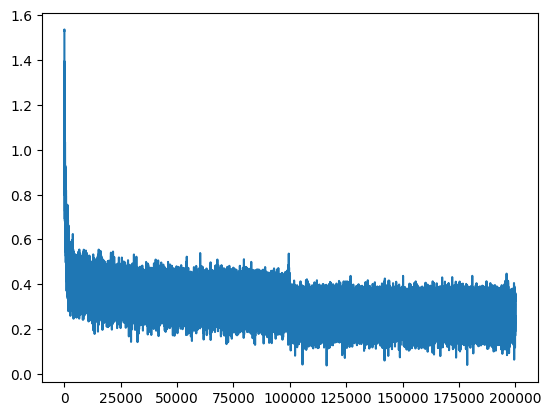

In [146]:
plt.plot(stepi, lossi)

In [147]:
emb = C[Xtr] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 50) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.8692, grad_fn=<NllLossBackward0>)

In [148]:
emb = C[Xdev] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 50) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2820, grad_fn=<NllLossBackward0>)

In [151]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

bopinder.
shaki.
zuisa.
bhupadi.
rekhni.
nirun.
mimsh.
prijuddin.
dhirresh.
matiya.
